In [11]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

# from utils import get_annotator_biases, get_texts_entropy, get_texts_std

from scipy.stats import entropy
from tqdm import tqdm
from typing import List, Callable

In [12]:
data_dir = Path('..') / '..' / '..' / 'storage' / 'doccano' / '2023_ecai_nlperspectives'

annotations_path = data_dir / 'data_with_min_20_annotations' / 'annotations.csv'
texts_path = data_dir / 'data_with_min_20_annotations' / 'data.csv'
questionnaire_path = data_dir / 'questionnaire_data' / 'HumaNLP_kwestionariusze.csv'
user_bias_path = data_dir / 'metrics' / 'user_bias.csv'

visualizations_dir = Path('visualizations')

annotations_df = pd.read_csv(annotations_path, 
                             sep=',', 
                             dtype={'text_id': np.int32, 'user_id': np.int32, 'Pozytywne': np.int32, 'Negatywne': np.int32, 'Radość': np.int32, 
                                    'Zachwyt': np.int32, 'Inspiruje': np.int32, 'Spokój': np.int32, 'Zaskoczenie': np.int32, 'Współczucie': np.int32, 
                                    'Strach': np.int32, 'Smutek': np.int32, 'Wstręt': np.int32, 'Złość': np.int32, 'Ironiczny': np.int32, 
                                    'Żenujący': np.int32, 'Wulgarny': np.int32, 'Polityczny': np.int32, 'Interesujący': np.int32, 
                                    'Zrozumiały': np.int32, 'Zgadzam się z tekstem': np.int32, 'Wierzę w tę informację': np.int32, 
                                    'Potrzebuję więcej informacji, aby ocenić ten tekst': np.int32, 'Czuję sympatię do autora': np.int32, 
                                    'Obraża mnie': np.int32, 'Może kogoś atakować / obrażać / lekceważyć': np.int32, 'Mnie bawi/śmieszy?': np.int32, 
                                    'Może kogoś bawić?': np.int32})

texts_df = pd.read_csv(texts_path, sep=',', dtype={'text_id': np.int32, 'text': str})

questionnaire_df = pd.read_csv(questionnaire_path, sep=';')
# remove duplicates (same user_id) in questionnaire_df
questionnaire_df = questionnaire_df.drop_duplicates(subset=['user_id'])

user_bias_df = pd.read_csv(user_bias_path, sep=',')

In [13]:
# merge annotations_df with questionnaire_df and user_bias_df
questionnaire_columns = ['user_id', 'FS_total', 'HSQ_A', 'HSQ_SE', 'HSQ_AG', 'HSQ_SD', 'IPIP_Ugodowość', 'IPIP_Ekstrawersja', 'IPIP_Sumienność', 'IPIP_Neurotyzm', 
                         'IPIP_Intelekt', 'PAQ', 'PHQ_9', 'PSS', 'RESS_Relaxation', 'RESS_Engagement', 'RESS_Rumination', 'RESS_Reappraisal', 'RESS_Distraction', 
                         'RESS_Suppression', 'SPANE_P', 'SPANE_N', 'SWLS_suma', 'PHQ_SD', 'PHQ_H', 'PHQ_GP', 'PHQ_RI']

data_df = questionnaire_df[questionnaire_columns].merge(annotations_df, 
                                                        on='user_id', how='left', suffixes=('_annotations', '_questionnaire')).merge(user_bias_df,
                                                                                                                                     on='user_id', how='left')

In [14]:
annotations_df.columns

Index(['text_id', 'user_id', 'Pozytywne', 'Negatywne', 'Radość', 'Zachwyt',
       'Inspiruje', 'Spokój', 'Zaskoczenie', 'Współczucie', 'Strach', 'Smutek',
       'Wstręt', 'Złość', 'Ironiczny', 'Żenujący', 'Wulgarny', 'Polityczny',
       'Interesujący', 'Zrozumiały', 'Zgadzam się z tekstem',
       'Wierzę w tę informację',
       'Potrzebuję więcej informacji, aby ocenić ten tekst',
       'Czuję sympatię do autora', 'Obraża mnie',
       'Może kogoś atakować / obrażać / lekceważyć', 'Mnie bawi/śmieszy?',
       'Może kogoś bawić?', 'updated_at'],
      dtype='object')

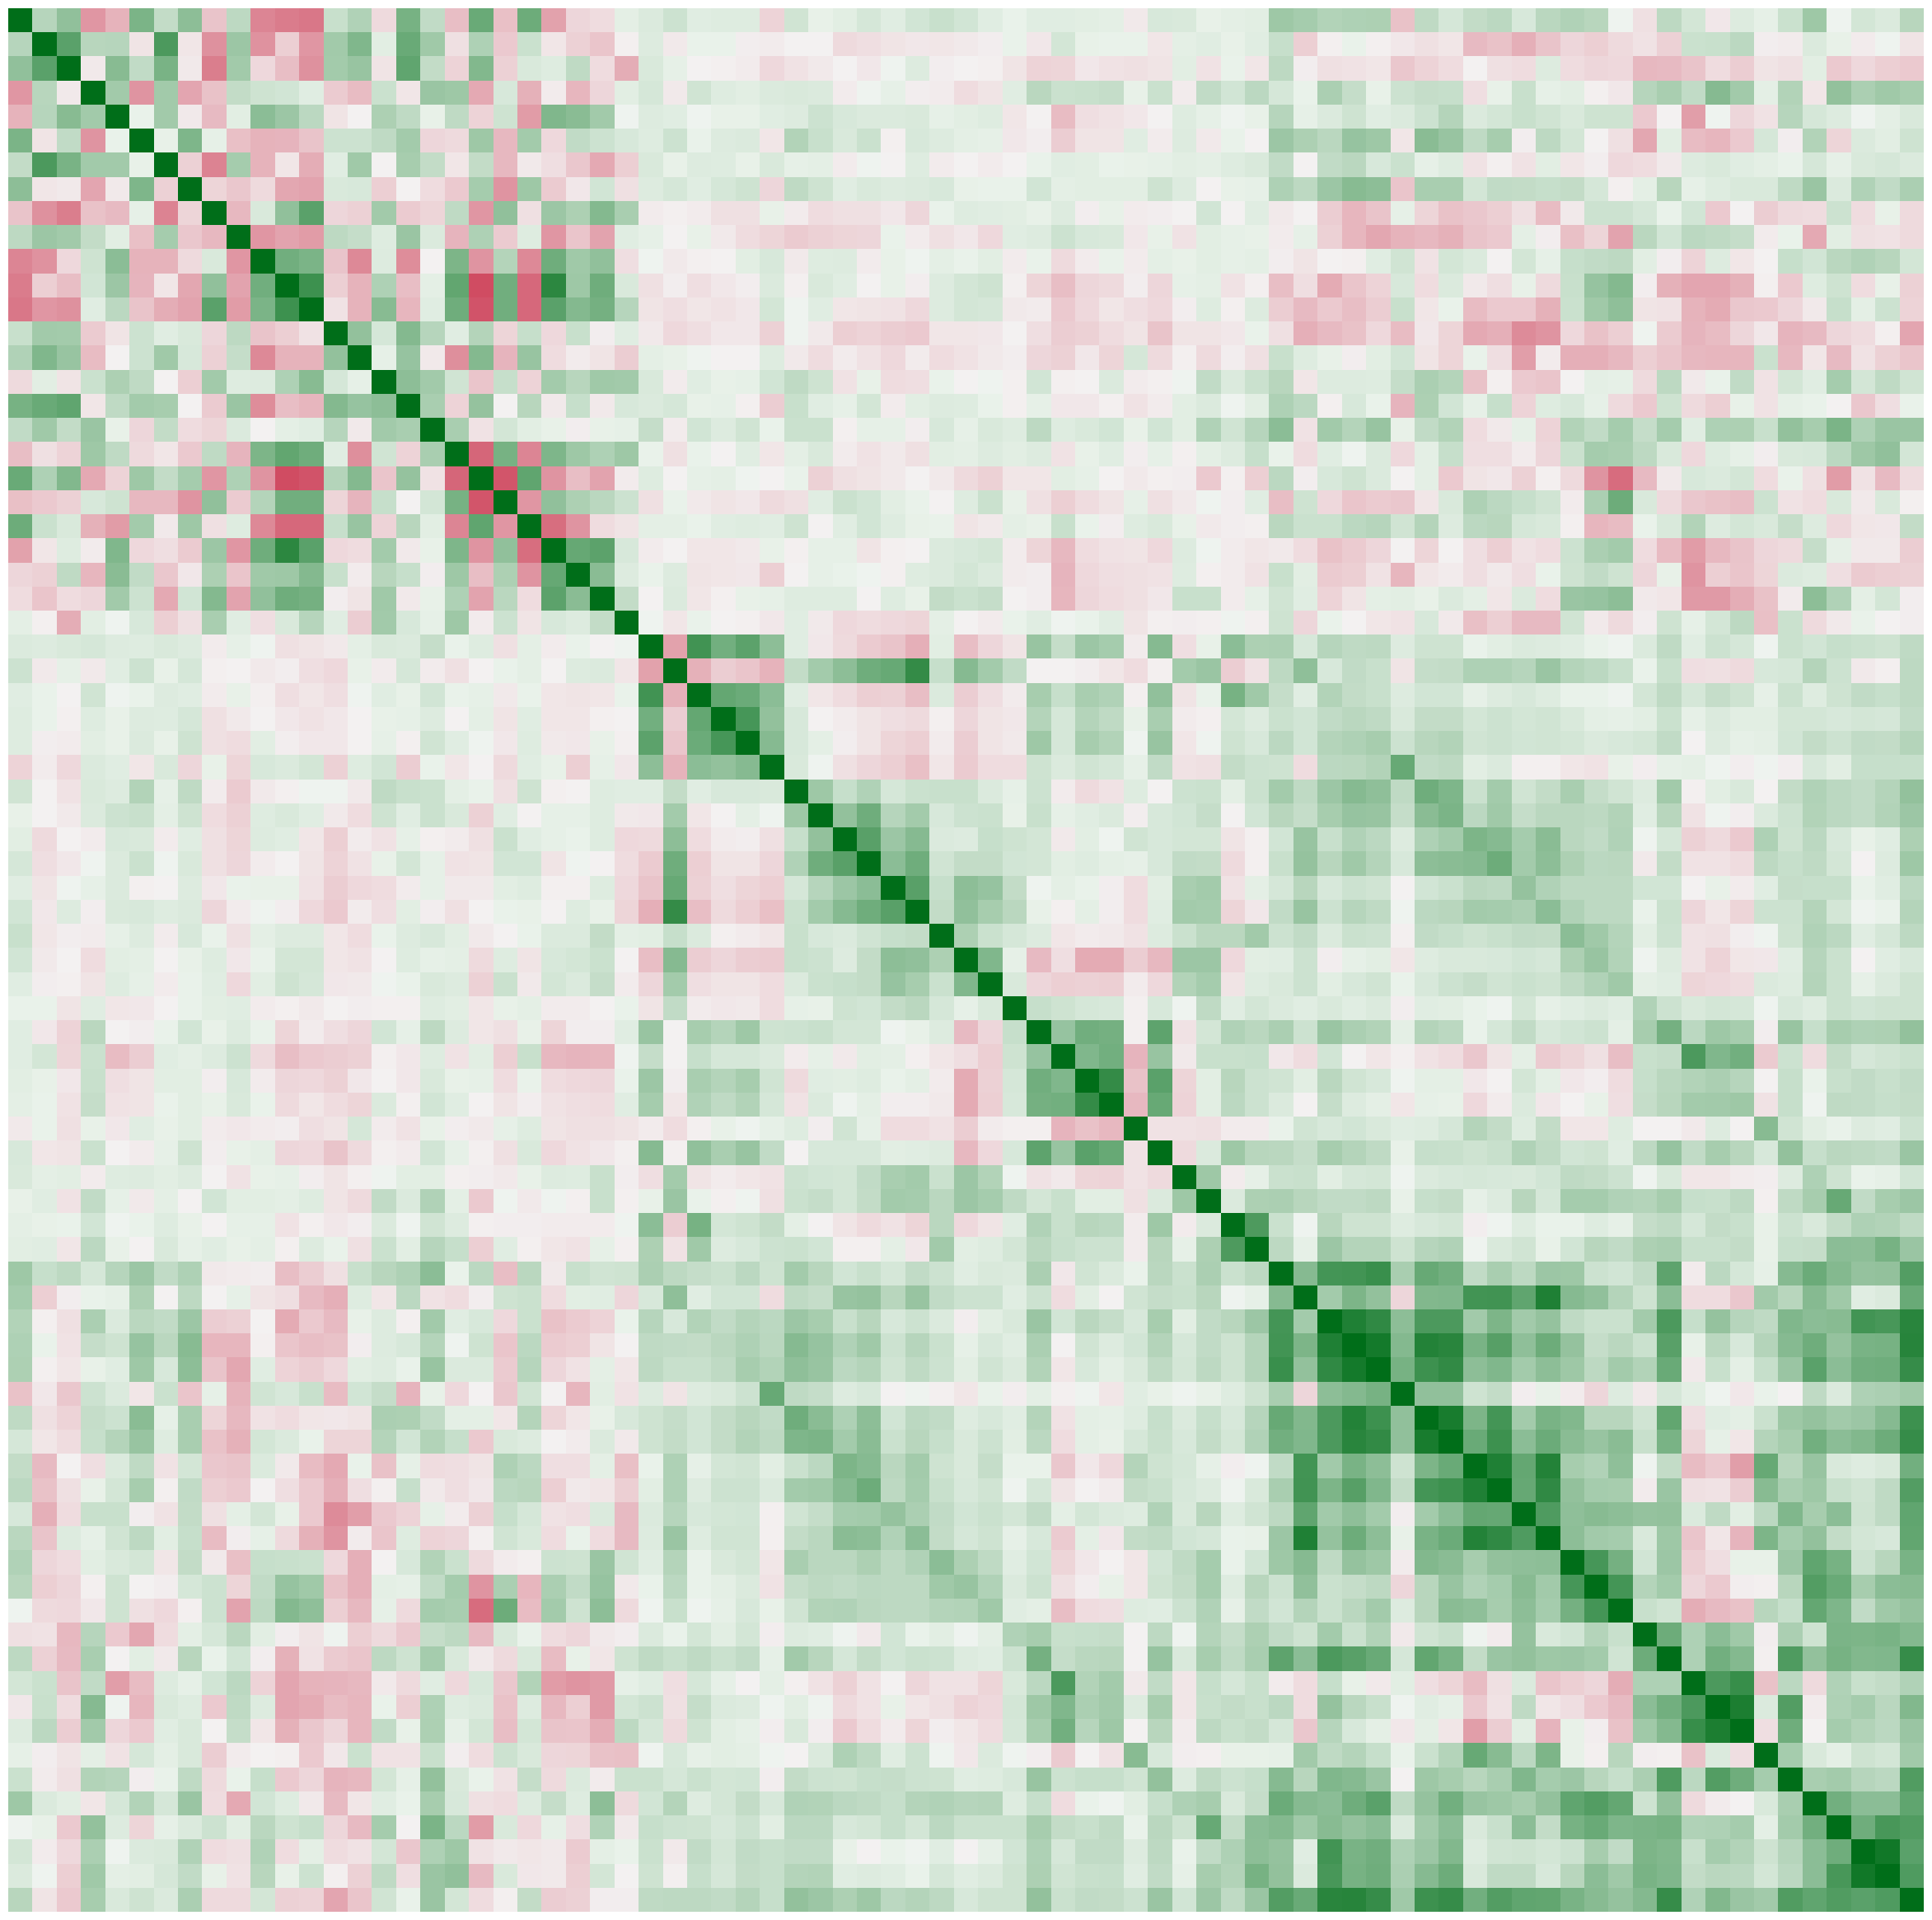

In [15]:
# numerical columns from data_df
excluded_columns = ['text_id', 'user_id', 'updated_at']
annotation_columns = ['Pozytywne', 'Negatywne', 'Radość', 'Zachwyt', 'Inspiruje', 'Spokój', 'Zaskoczenie', 'Współczucie', 'Strach', 'Smutek',
                      'Wstręt', 'Złość', 'Ironiczny', 'Żenujący', 'Wulgarny', 'Polityczny', 'Interesujący', 'Zrozumiały', 'Zgadzam się z tekstem',
                      'Wierzę w tę informację', 'Potrzebuję więcej informacji, aby ocenić ten tekst', 'Czuję sympatię do autora', 'Obraża mnie',
                      'Może kogoś atakować / obrażać / lekceważyć', 'Mnie bawi/śmieszy?', 'Może kogoś bawić?']
corr_columns = [col for col in data_df.columns.tolist() if col not in excluded_columns]

# users ommited during creation of user-aggregated heatmap
not_aggregated_users = []

# copy Dataframe from previously downloaded file
df = data_df.copy()

# leave only those text, where at least one annotation for each task is not a zero
avg_df = df.groupby('text_id').mean(numeric_only=True)
nonzero_avg_texts = avg_df[(avg_df[annotation_columns] > 0).all(axis=1)].index.tolist()
df = df[df['text_id'].isin(nonzero_avg_texts)]

# create new dataframe with specific columns
task_df = df[corr_columns]
corr = task_df.corr()

plt.figure(figsize=(30, 30))

# plt.title('Annotation-based average correlation')

# set color map for heatmap
# color map with white center
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=100, l=40, sep=1, as_cmap=True)

# color map with black center
# from matplotlib.colors import LinearSegmentedColormap
# rdgn = LinearSegmentedColormap.from_list('RkG', ['red','black','green'])

sns.heatmap(corr, 
            cmap=rdgn,
            cbar=False,
            annot=False,
            xticklabels=False,
            yticklabels=False,
            fmt='.2f',
            vmin=-1, 
            vmax=1,
            center=0)   
                             
plt.yticks(rotation=0)

if not os.path.exists(visualizations_dir):
    os.mkdir(visualizations_dir)

plt.savefig(visualizations_dir / 'doccano_annotation_questionnaire_bias.png', dpi=300)